In [1]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner

starry.config.quiet = True
np.random.seed(1)

/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper functions

In [2]:
def Inclination(name, testval=30):
    """
    An isotropic distribution for inclination angles (in degrees).
    
    """
    def logp(x):
        return tt.log(np.pi / 180 * tt.sin(x * np.pi / 180))

    def random(*args, **kwargs):
        return tt.arccos(pm.Uniform.dist(0, 1).random(*args, **kwargs)) * 180 / np.pi

    return pm.DensityDist(
        name,
        logp,
        random=random,
        initval=testval,
    )


def Angle(*args, **kwargs):
    """
    A uniform distribution for angles in [-180, 180).
    
    """
    if kwargs.get("testval", None) is not None:
        kwargs["testval"] *= np.pi / 180
    return 180 / np.pi * pmx.Angle(*args, **kwargs)


# Shorthand for the usual Uniform distribution
Uniform = pm.Uniform

In [3]:
def generate(t, params, seed=1, error=1e-3, visualize=True):
    """
    Generate a synthetic light curve.
    
    """
    # Set up the system
    map = starry.Map(15, 2)
    map.inc = params["star.inc"]["truth"]
    map[1] = params["star.u1"]["truth"]
    map[2] = params["star.u2"]["truth"]
    star = starry.Primary(map, m=params["star.m"]["truth"]) # *** maybe also `r`
    planet = starry.Secondary(
        starry.Map(),
        inc=params["planet.inc"]["truth"],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        w=params["planet.w"]["truth"],
        porb=params["planet.porb"]["truth"],
        t0=params["planet.t0"]["truth"],
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    
    # Get the flux design matrix
    theta = (360 * t / params["star.prot"]["truth"]) % 360
    A = map.design_matrix(
        theta=theta, xo=xo, yo=yo, zo=zo, ro=params["planet.r"]["truth"]
    ).eval()
    print(A.shape)
    
    # *** Draw 1 sample from the GP
    np.random.seed(seed)
    sp = StarryProcess(
        mu=params["gp.mu"]["truth"],
        sigma=params["gp.sigma"]["truth"],
        r=params["gp.r"]["truth"],
        c=params["gp.c"]["truth"],
        n=params["gp.n"]["truth"],
    )
    y = sp.sample_ylm().eval().reshape(-1)

    # Starry process Ylms are normalized so that they have
    # zero luminosity (i.e., a featureless star has Y_{0,0} = 0)
    # Let's renormalize it to unity, since that's the baseline
    # we want for transits
    y[0] += 1
    
    # Compute the light curve
    flux0 = A @ y


    mu_ylm = sp.mean_ylm
    mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
    mu_flux = tt.dot(A, mu_ylm)
    
    # Add photometric noise
    err = np.ones_like(flux0) * error
    flux = np.array(flux0)
    noise = np.random.randn(len(t)) * err
    flux += noise
    
    # *** Normalize the flux
    med_flux = np.median(flux)
    flux /= med_flux
    err /= med_flux
    
    # Visualize the system
    if visualize:
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))
        idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
        ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
        ax[0].set_aspect(1)
        ax[0].axis("off")
        map[:, :] = y
        map.show(ax=ax[0])
        ax[0].set_ylim(-3, 3)
        idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
        lat = 180 / np.pi * np.arcsin(yo[idx])
        lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
        lon = (lon + 180) % 360 - 180
        mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
        mask[mask == 1] = np.nan
        map.show(ax=ax[1], projection="rect")
        ax[1].plot(lon, lat + mask, "k-");
    
    return flux, err, med_flux, mu_flux

Based on Hogg's notes: https://ui.adsabs.harvard.edu/abs/2020arXiv200514199H/abstract,
I have $$ln L_m = -\frac{1}{2} r_m^T \Sigma^{-1} r_m - \frac{1}{2}ln\vert\Sigma\vert - \frac{K}{2} ln(2\pi)$$
$$r_m = f_m - \mu$$
from eq. (19) and (20):
$$\vert\Sigma\vert = \vert\Sigma_d\vert \vert\Sigma_s\vert  \vert\Sigma_s^{-1}\vert \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert $$
$$\vert\Sigma\vert = \vert\Sigma_d\vert \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert$$
$$ln \vert\Sigma\vert = ln \vert\Sigma_d\vert + ln \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert$$
from eq. (24):
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A (\Sigma_s^{-1}+A^T\Sigma_d^{-1}A)^{-1}A^T\Sigma_d^{-1}$$
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A (I+\Sigma_s A^T\Sigma_d^{-1}A)^{-1}\Sigma_s A^T\Sigma_d^{-1}$$
$$U = I+\Sigma_s A^T\Sigma_d^{-1}A$$
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A U^{-1}\Sigma_s A^T\Sigma_d^{-1}$$
$$Q = r_m^T \Sigma^{-1} r_m = r_m^T(\Sigma_d^{-1} - \Sigma_d^{-1} A \Sigma_s U^{-1}A^T\Sigma_d^{-1})r_m$$
$$v = A^T\Sigma_d^{-1}r_m = A^T r_m/\sigma^2$$
$$v^T = r_m^T\Sigma_d^{-1}A$$
$$Q = r_m^T\Sigma_d^{-1}r_m - v^T \Sigma_s U^{-1}v$$

In [4]:
def bin_out_of_transit(t, flux, err, params, dt=0.1, binsize=30):
    """
    Bin the out of transit points to speed things up.
    
    """
    # Find in-transit and out-of-transit points
    idx = np.zeros(len(t), dtype=bool)
    ntransits = int(np.ceil(t[-1] / params["planet.porb"]["truth"]))
    for n in range(ntransits):
        t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
        idx |= ((t > t0 - dt) & (t < t0 + dt))
    t_in = t[idx]
    f_in = flux[idx]
    t_out = t[~idx]
    f_out = flux[~idx]

    # Make the size of the out-of-transit array divisible by binsize
    # so we can bin by simple array reshaping
    trim = len(t_out) % binsize
    t_out = t_out[:-trim]
    f_out = f_out[:-trim]

    # We need to be careful not to bin *across* the transit, so
    # let's NaN-out points right _before_ each transit
    f_out[np.where(np.diff(t_out) > 0.1)] = np.nan

    # Bin the out-of-transit data
    t_out = t_out.reshape(-1, binsize).mean(axis=1)
    f_out = f_out.reshape(-1, binsize).mean(axis=1)

    # Remove any nans (the averages *across* transits)
    idx = np.isnan(f_out)
    t_out = t_out[~idx]
    f_out = f_out[~idx]

    # Error arrays
    e_in = err[0] * np.ones_like(t_in)
    e_out = (err[0] / np.sqrt(binsize)) * np.ones_like(t_out)

    # Sort and merge the arrays
    t_ = np.concatenate((t_in, t_out))
    f_ = np.concatenate((f_in, f_out))
    e_ = np.concatenate((e_in, e_out))
    idx = np.argsort(t_)
    t_ = t_[idx]
    flux_ = f_[idx]
    err_ = e_[idx]

    return t_, flux_, err_

some linear algebra:
$$\Sigma_d^{-1}r_m = r_m\frac{1}{\sigma^2}$$
$$r_m^T\Sigma_d^{-1} = (r_m\frac{1}{\sigma^2})^T$$
$$r_m^T\Sigma_d^{-1}r_m = r_m^2/\sigma^2$$

Solving for mean and covariance of $f_{obs}$
$$m=1/\alpha$$
$$f_{obs} = f_{true}{\alpha}+\epsilon$$
$$f_{true} \sim \mathcal{N}(\mu,\Sigma)$$
$$\epsilon \sim \mathcal{N}(0,\sigma^2 I)$$
$$f_{obs} \sim \mathcal{N}(\frac{\mu}{m},\frac{\Sigma}{m^2}+\sigma^2I)$$
Now, I need to change $\Sigma$:
$$\tilde\Sigma^{-1} = (\frac{1}{m^2}\Sigma)^{-1} = m^2\Sigma^{-1}$$
$$\tilde Q = m^2 Q$$
$$ln\vert\tilde\Sigma\vert = ln\vert\frac{1}{m^2}\Sigma\vert = ln((\frac{1}{m^2})^n\vert\Sigma\vert) = -2n ln(m)+ ln\vert\Sigma\vert$$

In [5]:
def gp_model(t, flux, err, params):

    # Helper function to instantiate parameters
    def parameter(name):
        param = params[name]
        if param.get("free", False):
            args = param.get("args", [])
            kwargs = param.get("kwargs", {})
            testval = param.get("testval", param["truth"])
            return param["dist"](name, *args, testval=testval, **kwargs)
        else:
            return param["truth"]
    
    
    starry.config.lazy = True
    
    with pm.Model() as model:

        # Instantiate the system
        map = starry.Map(15, 2)
        map.inc = parameter("star.inc")
        map[1] = parameter("star.u1")
        map[2] = parameter("star.u2")
        star = starry.Primary(map, m=parameter("star.m")) # *** maybe also `r` for the star
        planet = starry.Secondary(
            starry.Map(),
            inc=parameter("planet.inc"),
            ecc=parameter("planet.ecc"),
            Omega=parameter("planet.Omega"),
            w=parameter("planet.w"),
            porb=parameter("planet.porb"),
            t0=parameter("planet.t0"),
        )
        sys = starry.System(star, planet)
        xo, yo, zo = sys.position(t)

        # Get the flux design matrix
        theta = (360 * t / parameter("star.prot")) % 360
        A = map.design_matrix(
            theta=theta,
            xo=xo[1], # *** these were wrong! [0] = star; [1] = planet
            yo=yo[1],
            zo=zo[1],
            ro=parameter("planet.r"),
        )

        # Instantiate the GP
        # sigma = pm.Uniform("sigma", 1.0, 10.0)
        sp = StarryProcess(
            mu=parameter("gp.mu"),
            sigma=parameter("gp.sigma"),
            # sigma=sigma,
            r=parameter("gp.r"),
            c=parameter("gp.c"),
            n=parameter("gp.n"),
            marginalize_over_inclination=False,  # *** we know the inclination
            normalized=False,  # *** we're modeling the normalization explicitly
        )
        norm = parameter("gp.norm")
        
        A = A / norm
        
        '''
        # Compute the flux covariance
        cov_ylm = sp.cov_ylm
        cov_flux = tt.dot(tt.dot(A, cov_ylm), tt.transpose(A)) / norm ** 2
        cov_flux += tt.diag(err) ** 2

        # Compute the flux mean; remember to offset Y_{0,0} by one
        mu_ylm = sp.mean_ylm
        mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
        mu_flux = tt.dot(A, mu_ylm) / norm

        # Marginal likelihood
        pm.MvNormal("marginal", mu=mu_flux, cov=cov_flux, observed=flux)
        '''
        Sigma_s = sp.cov_ylm 
        mu_ylm = sp.mean_ylm
        mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
        mu_flux = tt.dot(A, mu_ylm) #/ norm
        K = len(t)

        U = np.eye(256) +tt.dot(Sigma_s, tt.dot(A.T, A/tt.square(err[:,None])))

        log_sigmadet = 2*tt.sum(tt.log(err)) + pmm.logdet(U) 
        # log_sigmadet -= 2*256*tt.log(norm)

        r = tt.as_tensor_variable(flux) - mu_flux
        v = tt.dot(A.T,(r/tt.square(err)))
        Q = tt.sum(tt.square(r/err)) - tt.dot(v.T,tt.slinalg.solve(U,tt.dot(v,Sigma_s)))

        loglike = -0.5 * Q
        loglike -= 0.5  * log_sigmadet
        loglike -= 0.5 * K * tt.log(2 * np.pi)

        pm.Potential("lnlike", loglike)

        
        return model

## Generate a light curve

(721, 256)


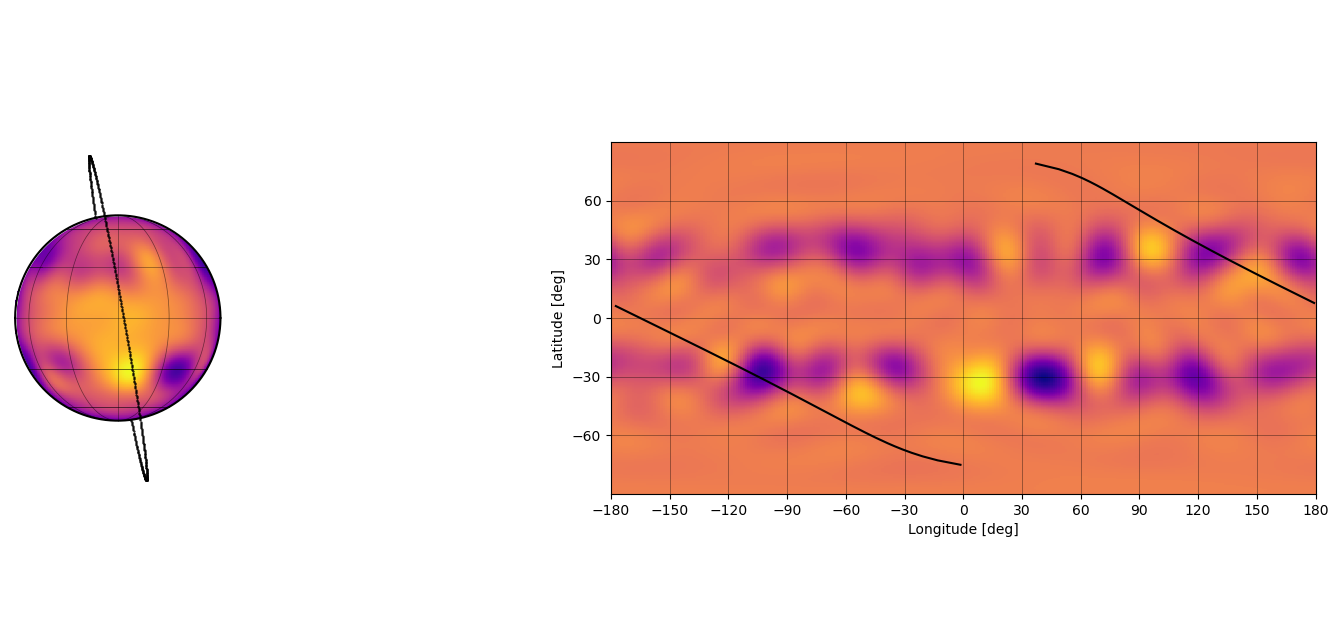

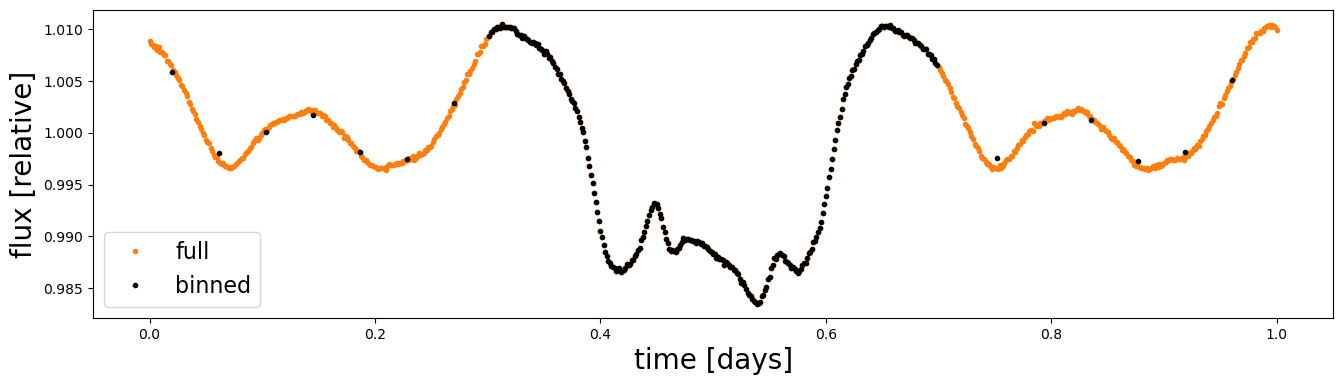

In [6]:
# *** True parameters & priors
params = {
    "planet.inc": {"truth": 88.0, "dist": Inclination},
    "planet.ecc": {"truth": 0.0, "dist": Uniform, "args": [0.0, 0.4]},
    "planet.Omega": {"truth": 100, "dist": Angle},
    "planet.w": {"truth": 0.0, "dist": Angle},
    "planet.porb": {"truth": 1.0, "dist": Uniform, "args": [0.975, 1.025]},
    "planet.t0": {"truth": 0.5, "dist": Uniform, "args": [0.475, 0.525]},
    "planet.r": {"truth": 0.1, "dist": Uniform, "args": [0.06, 0.14]},
    "star.inc": {"truth": 90, "dist": Inclination},
    "star.m": {"truth": 0.5, "dist": Uniform, "args": [0.4, 0.6]},
    "star.u1": {"truth": 0.4, "dist": Uniform, "args": [0.0, 0.6]},
    "star.u2": {"truth": 0.2, "dist": Uniform, "args": [0.0, 0.4]},
    "star.prot": {"truth": 0.34, "dist": pm.Uniform, "args": [0.1, 1.0]},
    "gp.r": {"truth": 10, "dist": Uniform, "args": [5.0, 25.0]},
    "gp.c": {"truth": 0.1, "dist": Uniform, "args": [0.01, 0.5]},
    "gp.n": {"truth": 20, "dist": Uniform, "args": [1, 30]},
    "gp.mu": {"truth": 30, "dist": Uniform, "args": [0.0, 80.0]},
    "gp.sigma": {"truth": 5, "dist": Uniform, "args": [1.0, 10]},
    "gp.norm": {"truth": 1, "dist": Uniform, "args": [0.8, 1.2]}
}

# *** Time array (1 day @ 2 min cadence)
t = np.arange(0, 1, 2 / 24 / 60)

# Get the light curve
flux, err, med_flux, mu_flux = generate(t, params, error=1e-4)

# Get the binned light curve
t_, flux_, err_ = bin_out_of_transit(t, flux, err, params, dt=0.2)

# Plot the data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(t, flux, "C1.", alpha=1, label="full")
ax.plot(t_, flux_, "k.", label="binned")
ax.set_ylabel("flux [relative]", fontsize=20)
ax.set_xlabel("time [days]", fontsize=20)
ax.legend(fontsize=16);

In [7]:
params['gp.norm']['truth'] = med_flux

# Inference

In [8]:
# Set some free params & get the model
p = dict(params)
p["gp.mu"]["free"] = True
p["gp.sigma"]["free"] = True
p["gp.n"]["free"] = True
p["gp.c"]["free"] = True
p["gp.r"]["free"] = True
p["gp.norm"]["free"] = True
free = [x for x in p.keys() if p[x].get("free", False)]
model = gp_model(t, flux, err, p)

In [9]:
from pymc3.variational.callbacks import CheckParametersConvergence

In [10]:
with model:
    mean_field = pm.fit(method="advi", callbacks=[CheckParametersConvergence(diff='absolute')])

Finished [100%]: Average Loss = -5,321.3


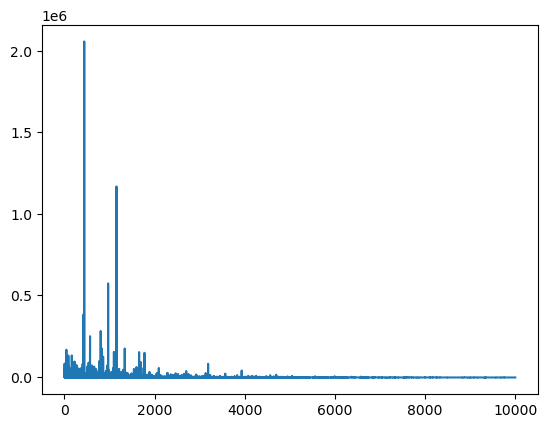

In [11]:
plt.plot(mean_field.hist);

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


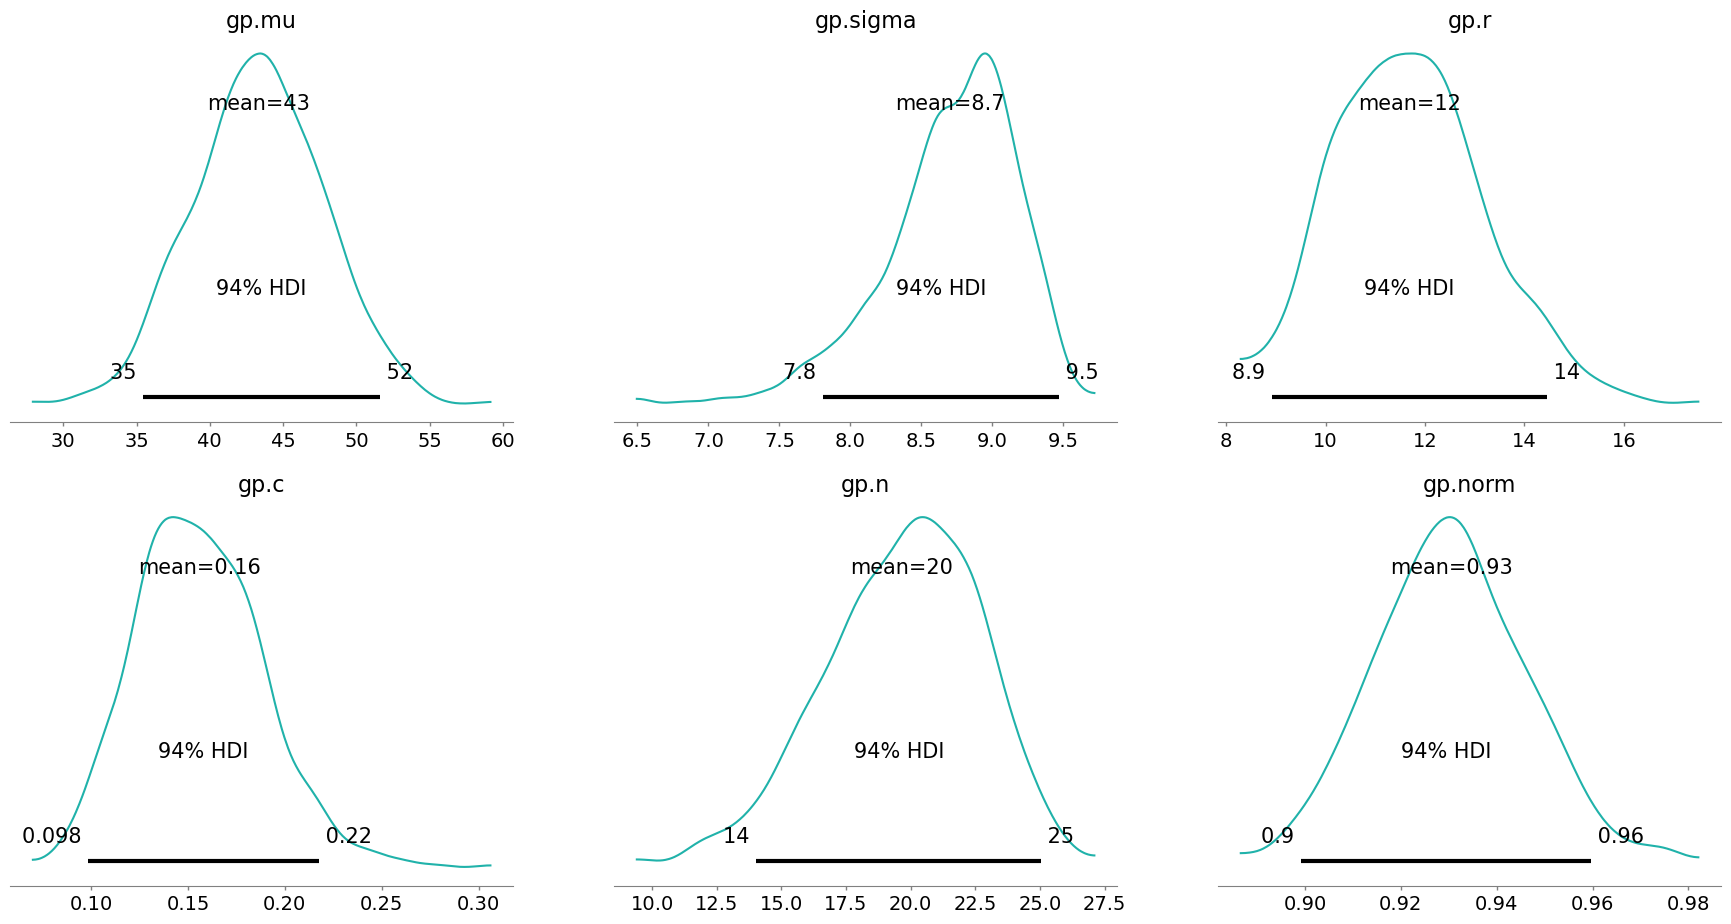

In [12]:
import arviz as az
az.plot_posterior(mean_field.sample(1000), color="LightSeaGreen");

In [13]:
help(pm.callbacks.CheckParametersConvergence)

Help on class CheckParametersConvergence in module pymc3.variational.callbacks:

class CheckParametersConvergence(Callback)
 |  CheckParametersConvergence(every=100, tolerance=0.001, diff='relative', ord=inf)
 |  
 |  Convergence stopping check
 |  
 |  Parameters
 |  ----------
 |  every: int
 |      check frequency
 |  tolerance: float
 |      if diff norm < tolerance: break
 |  diff: str
 |      difference type one of {'absolute', 'relative'}
 |  ord: {non-zero int, inf, -inf, 'fro', 'nuc'}, optional
 |      see more info in :func:`numpy.linalg.norm`
 |  
 |  Examples
 |  --------
 |  >>> with model:
 |  ...     approx = pm.fit(
 |  ...         n=10000, callbacks=[
 |  ...             CheckParametersConvergence(
 |  ...                 every=50, diff='absolute',
 |  ...                 tolerance=1e-4)
 |  ...         ]
 |  ...     )
 |  
 |  Method resolution order:
 |      CheckParametersConvergence
 |      Callback
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __

In [14]:
with model:
    advi = pm.ADVI()

In [15]:
advi.approx

In [16]:
advi.approx.shared_params

{'mu': mu, 'rho': rho}

In [17]:
advi.approx.mean.eval(), advi.approx.std.eval()

(array([-1.49165488, -1.09861229, -0.51082562,  0.64185389, -0.22314355,
        -0.54769827]),
 array([0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
        0.69314718]))

In [18]:
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval,  # callable that returns std
)

In [19]:
approx = advi.fit(10000, callbacks=[tracker])

Finished [100%]: Average Loss = -5,329.7


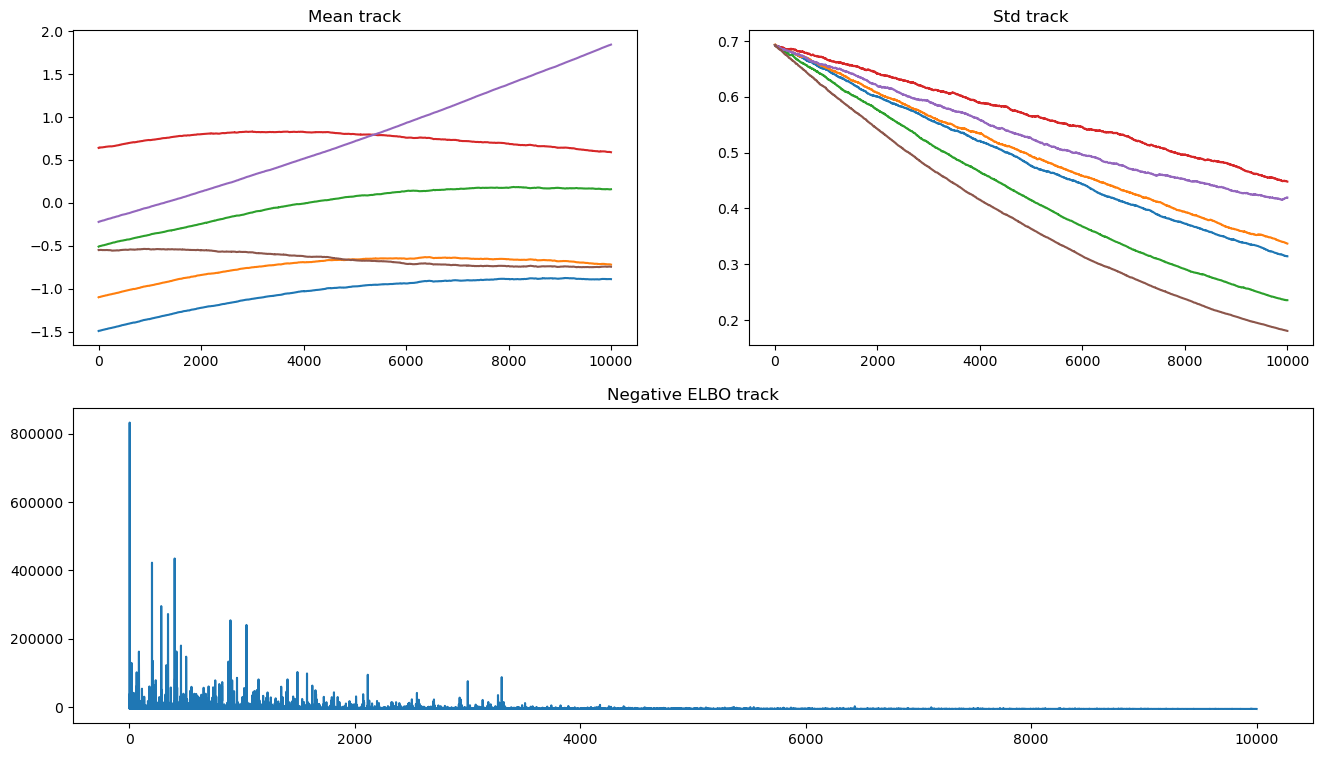

In [20]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker["mean"])
mu_ax.set_title("Mean track")
std_ax.plot(tracker["std"])
std_ax.set_title("Std track")
hist_ax.plot(advi.hist)
hist_ax.set_title("Negative ELBO track");

In [21]:
advi.refine(100000)

Finished [100%]: Average Loss = -5,432.5


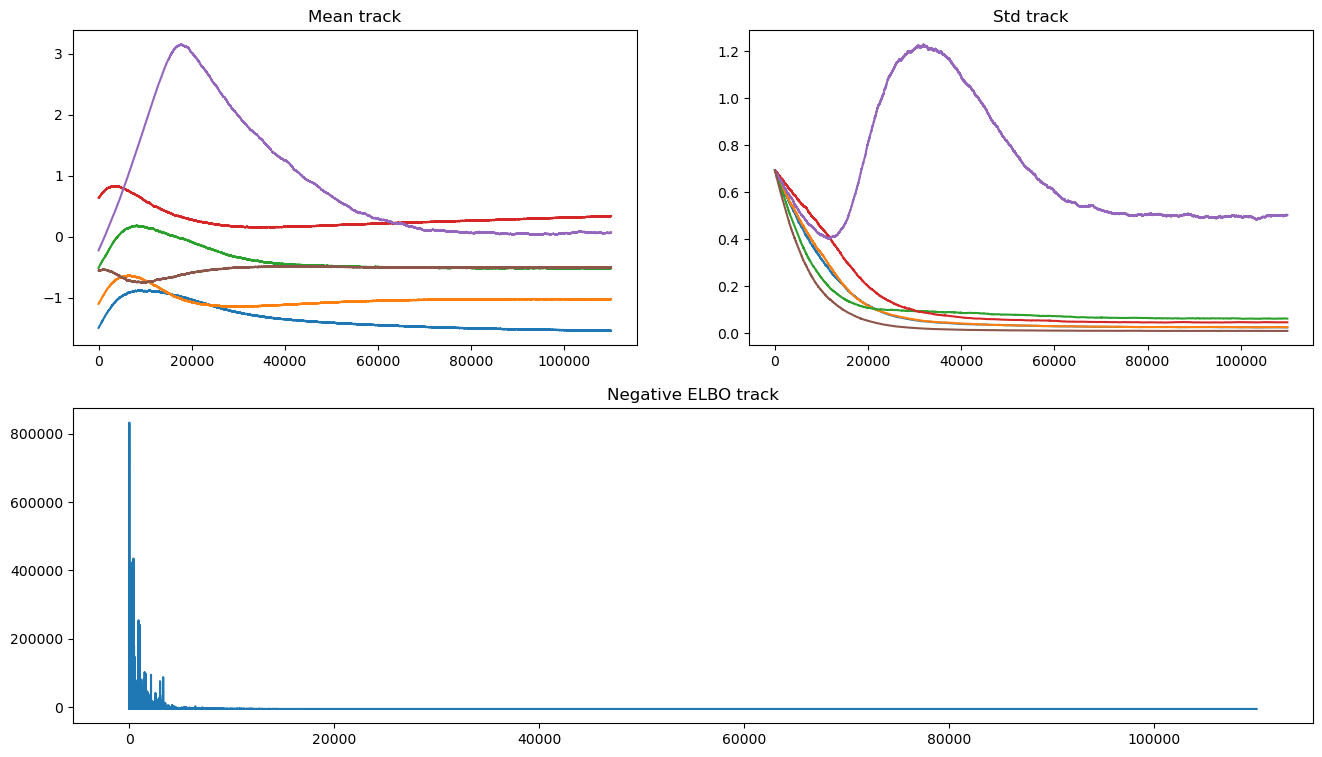

In [22]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker["mean"])
mu_ax.set_title("Mean track")
std_ax.plot(tracker["std"])
std_ax.set_title("Std track")
hist_ax.plot(advi.hist)
hist_ax.set_title("Negative ELBO track");

In [24]:
# NUTS
with model:
    trace = pm.sample(100, cores=1)

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_1125/1501957230.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(100, cores=1)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [gp.norm, gp.n, gp.c, gp.r, gp.sigma, gp.mu]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 38809 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6732227546983367, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


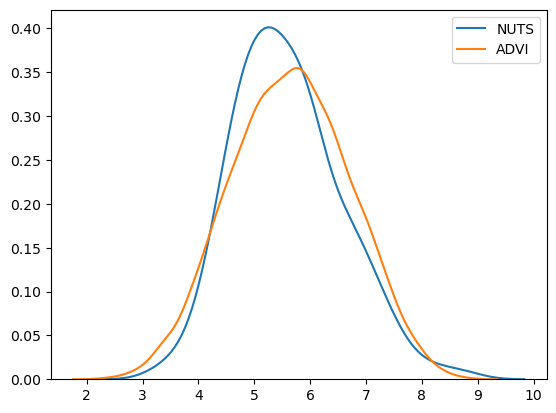

In [25]:
import seaborn as sns

ax = sns.kdeplot(trace["gp.sigma"], label="NUTS")
sns.kdeplot(approx.sample(10000)["gp.sigma"], label="ADVI");

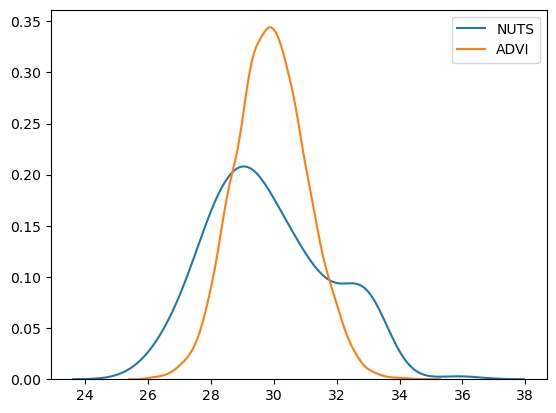

In [26]:
import seaborn as sns

ax = sns.kdeplot(trace["gp.mu"], label="NUTS")
sns.kdeplot(approx.sample(10000)["gp.mu"], label="ADVI");

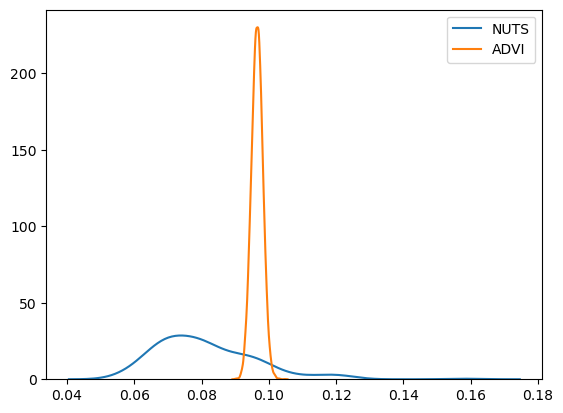

In [28]:
import seaborn as sns

ax = sns.kdeplot(trace["gp.c"], label="NUTS")
sns.kdeplot(approx.sample(10000)["gp.c"], label="ADVI");

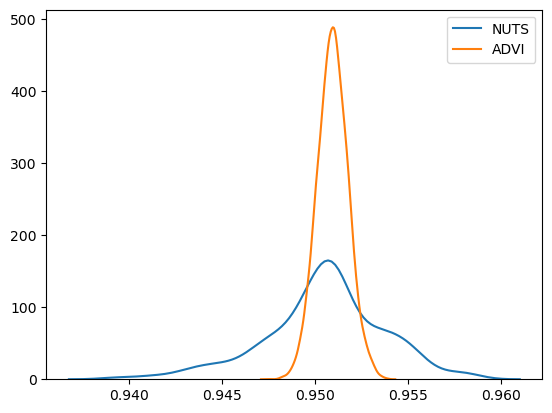

In [29]:
ax = sns.kdeplot(trace["gp.norm"], label="NUTS")
sns.kdeplot(approx.sample(10000)["gp.norm"], label="ADVI");

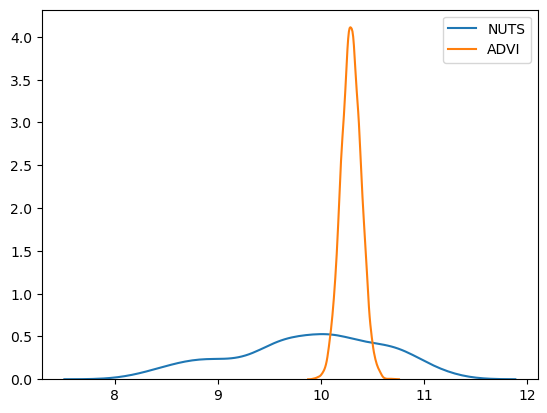

In [30]:
ax = sns.kdeplot(trace["gp.r"], label="NUTS")
sns.kdeplot(approx.sample(10000)["gp.r"], label="ADVI");

In [31]:
with model:
    svgd_approx = pm.fit(
        300,
        method="svgd",
        inf_kwargs=dict(n_particles=1000),
        obj_optimizer=pm.sgd(learning_rate=0.01),
    )

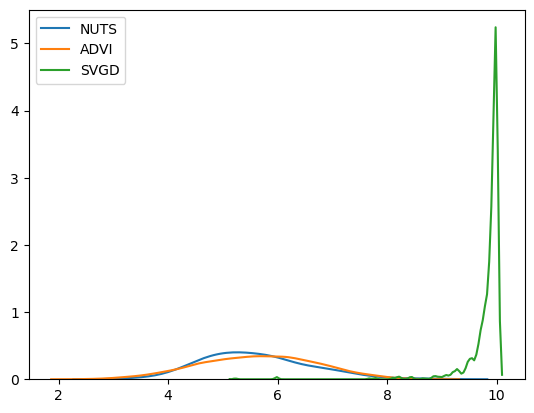

In [32]:
ax = sns.kdeplot(trace["gp.sigma"], label="NUTS")
sns.kdeplot(approx.sample(10000)["gp.sigma"], label="ADVI")
sns.kdeplot(svgd_approx.sample(2000)["gp.sigma"], label="SVGD");

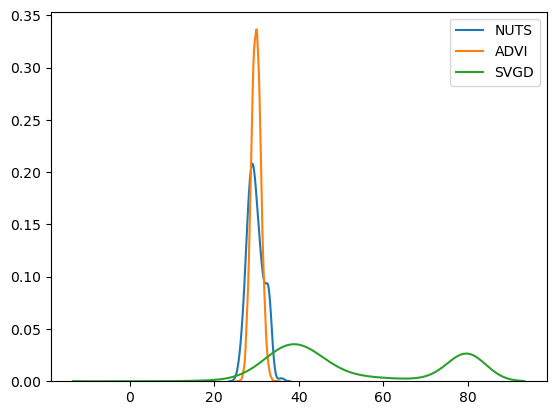

In [33]:
ax = sns.kdeplot(trace["gp.mu"], label="NUTS")
sns.kdeplot(approx.sample(10000)["gp.mu"], label="ADVI")
sns.kdeplot(svgd_approx.sample(2000)["gp.mu"], label="SVGD");

In [34]:
az_trace = az.from_netcdf('sampler_64000_gps.nc')

In [39]:
samples_fromfile = az_trace.to_dataframe()

In [40]:
samples_fromfile = samples_fromfile.iloc[:, 2:9]
samples_fromfile = samples_fromfile.iloc[:,:-1]

In [44]:
from starry_process import MCMCInterface

with model:
    mci = MCMCInterface()

In [45]:
samples_fromfile = mci.transform(samples_fromfile, varnames=free)

100%|██████████| 15000/15000 [18:15<00:00, 13.69it/s] 


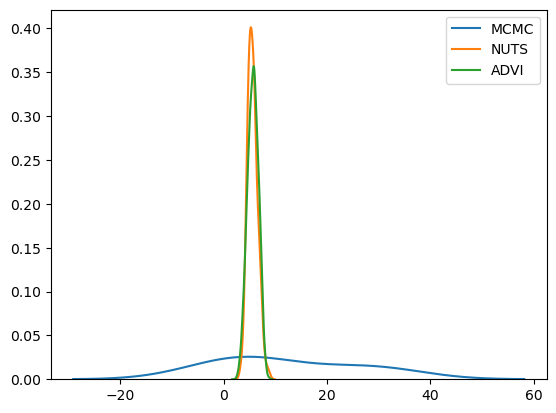

In [55]:
ax = sns.kdeplot(np.array(samples_fromfile)[-2], label="MCMC")
ax = sns.kdeplot(trace["gp.sigma"], label="NUTS")
sns.kdeplot(approx.sample(10000)["gp.sigma"], label="ADVI");

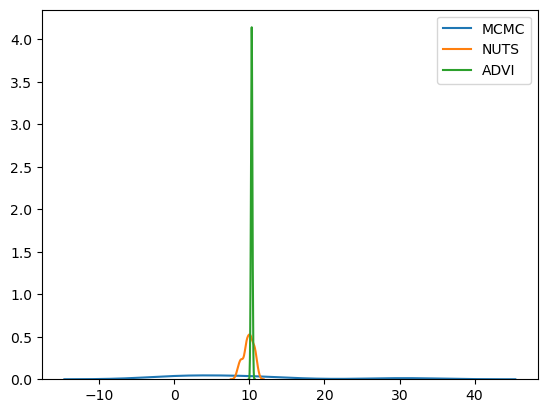

In [53]:
ax = sns.kdeplot(np.array(samples_fromfile)[0], label="MCMC")
ax = sns.kdeplot(trace["gp.r"], label="NUTS")
sns.kdeplot(approx.sample(10000)["gp.r"], label="ADVI");